In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1

In [5]:
# 脚本现在开始
factor = factors.factor_large_trade_ratio()
periods = factor.params["period"]
signal_name_format = factor.factor_name

In [ ]:
# %%time
# 构造因子

for product in product_list:
    date_list = helper.get_dates_list(product)
    print(product)
    helper.parLapply(date_list, 
                    factor_analysis.merge_metric_trades_and_construct_indicators,
                    product=product,
                    signal_list=[factor],
                    overwrite=True,)



In [4]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    
tick_ret = helper.get_field_data(product_list, "ret")

no file found for BTCUSDT trade.buy_power.large.1024 2023-07-24
no file found for BTCUSDT trade.buy_power.large.1024 2023-07-25
no file found for BTCUSDT trade.buy_power.large.1024 2023-07-26
no file found for BTCUSDT trade.buy_power.large.2048 2023-07-24
no file found for BTCUSDT trade.buy_power.large.2048 2023-07-25
no file found for BTCUSDT trade.buy_power.large.2048 2023-07-26
no file found for BTCUSDT trade.buy_power.large.4096 2023-07-24
no file found for BTCUSDT trade.buy_power.large.4096 2023-07-26
no file found for BTCUSDT trade.buy_power.large.4096 2023-07-25
no file found for BTCUSDT trade.buy_power.large.8192 2023-07-24
no file found for BTCUSDT trade.buy_power.large.8192 2023-07-25
no file found for BTCUSDT trade.buy_power.large.8192 2023-07-26
no file found for BTCUSDT trade.buy_power.large.16384 2023-07-24
no file found for BTCUSDT trade.buy_power.large.16384 2023-07-26
no file found for BTCUSDT trade.buy_power.large.16384 2023-07-25


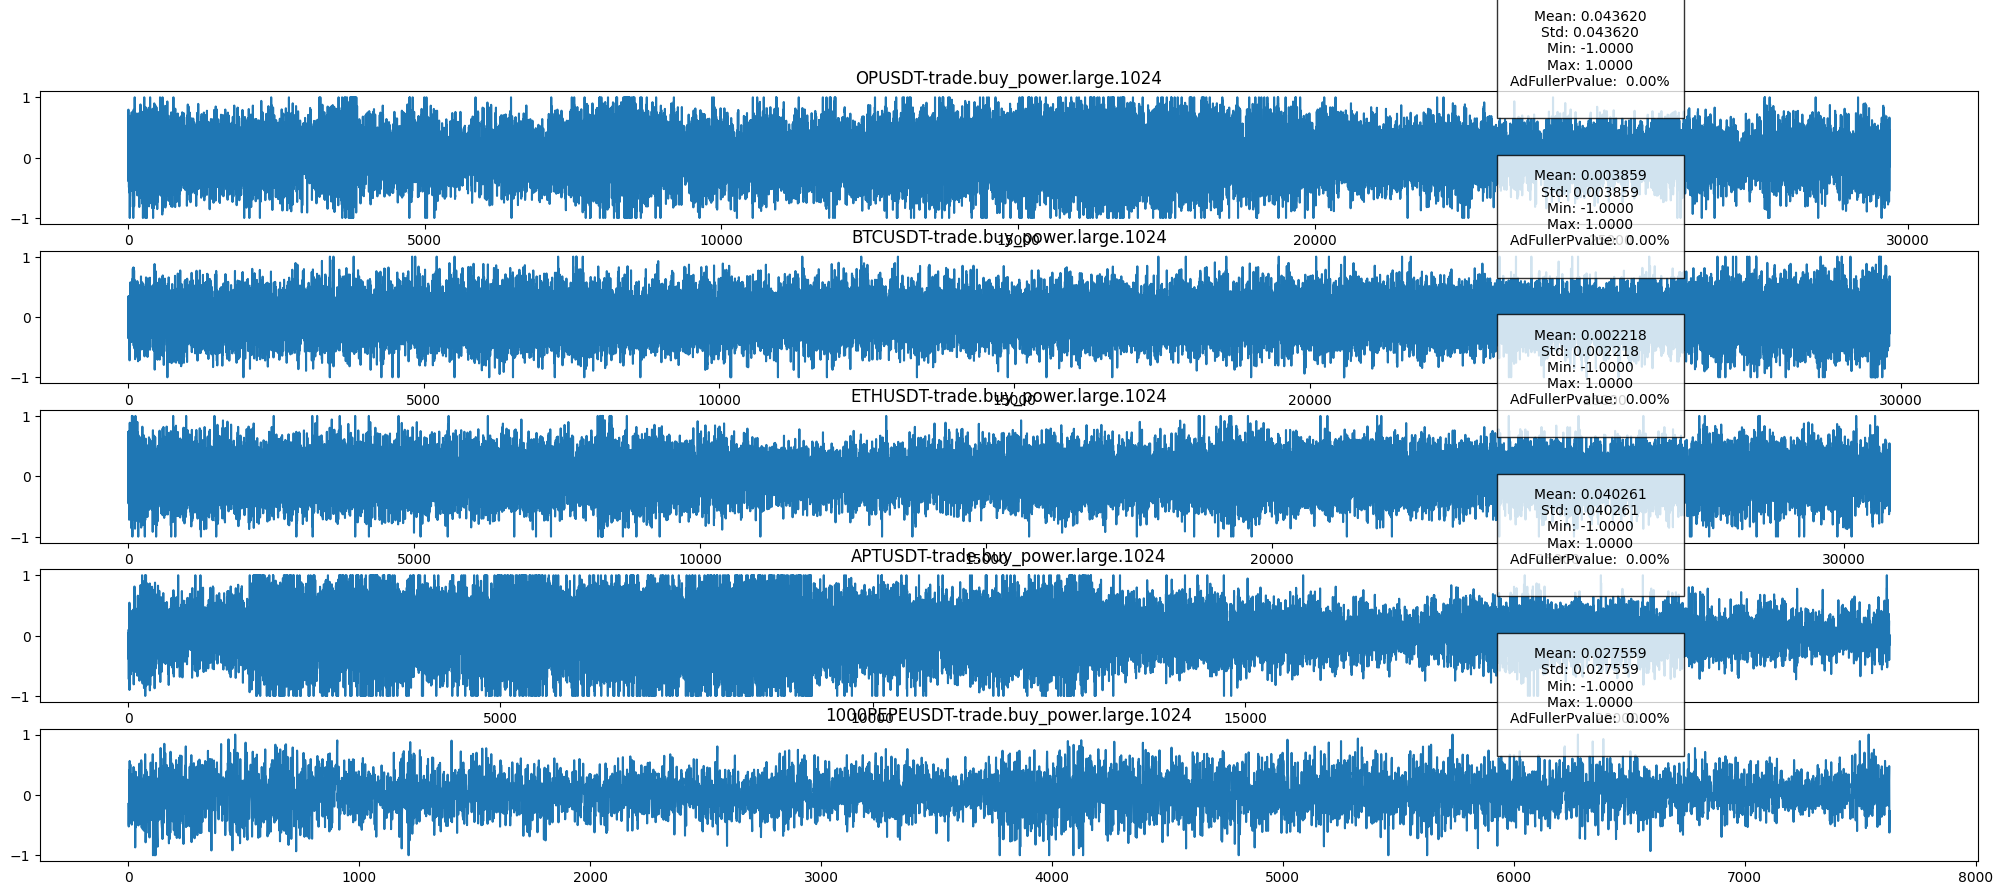

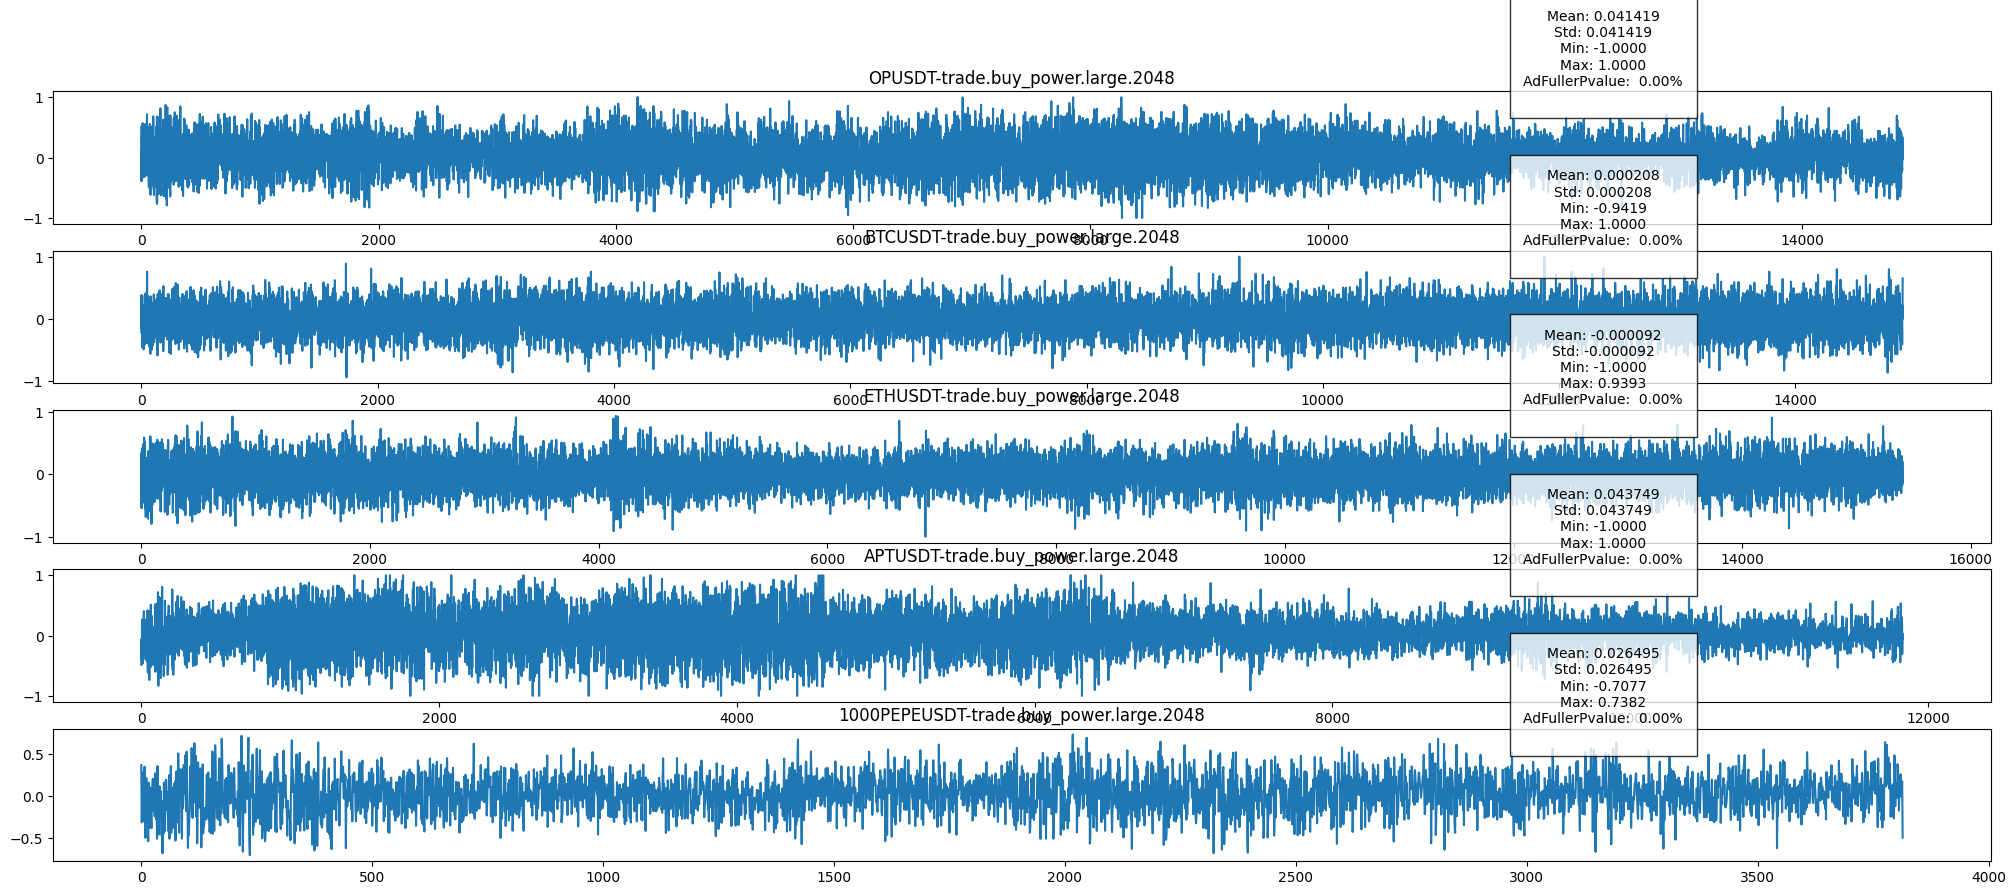

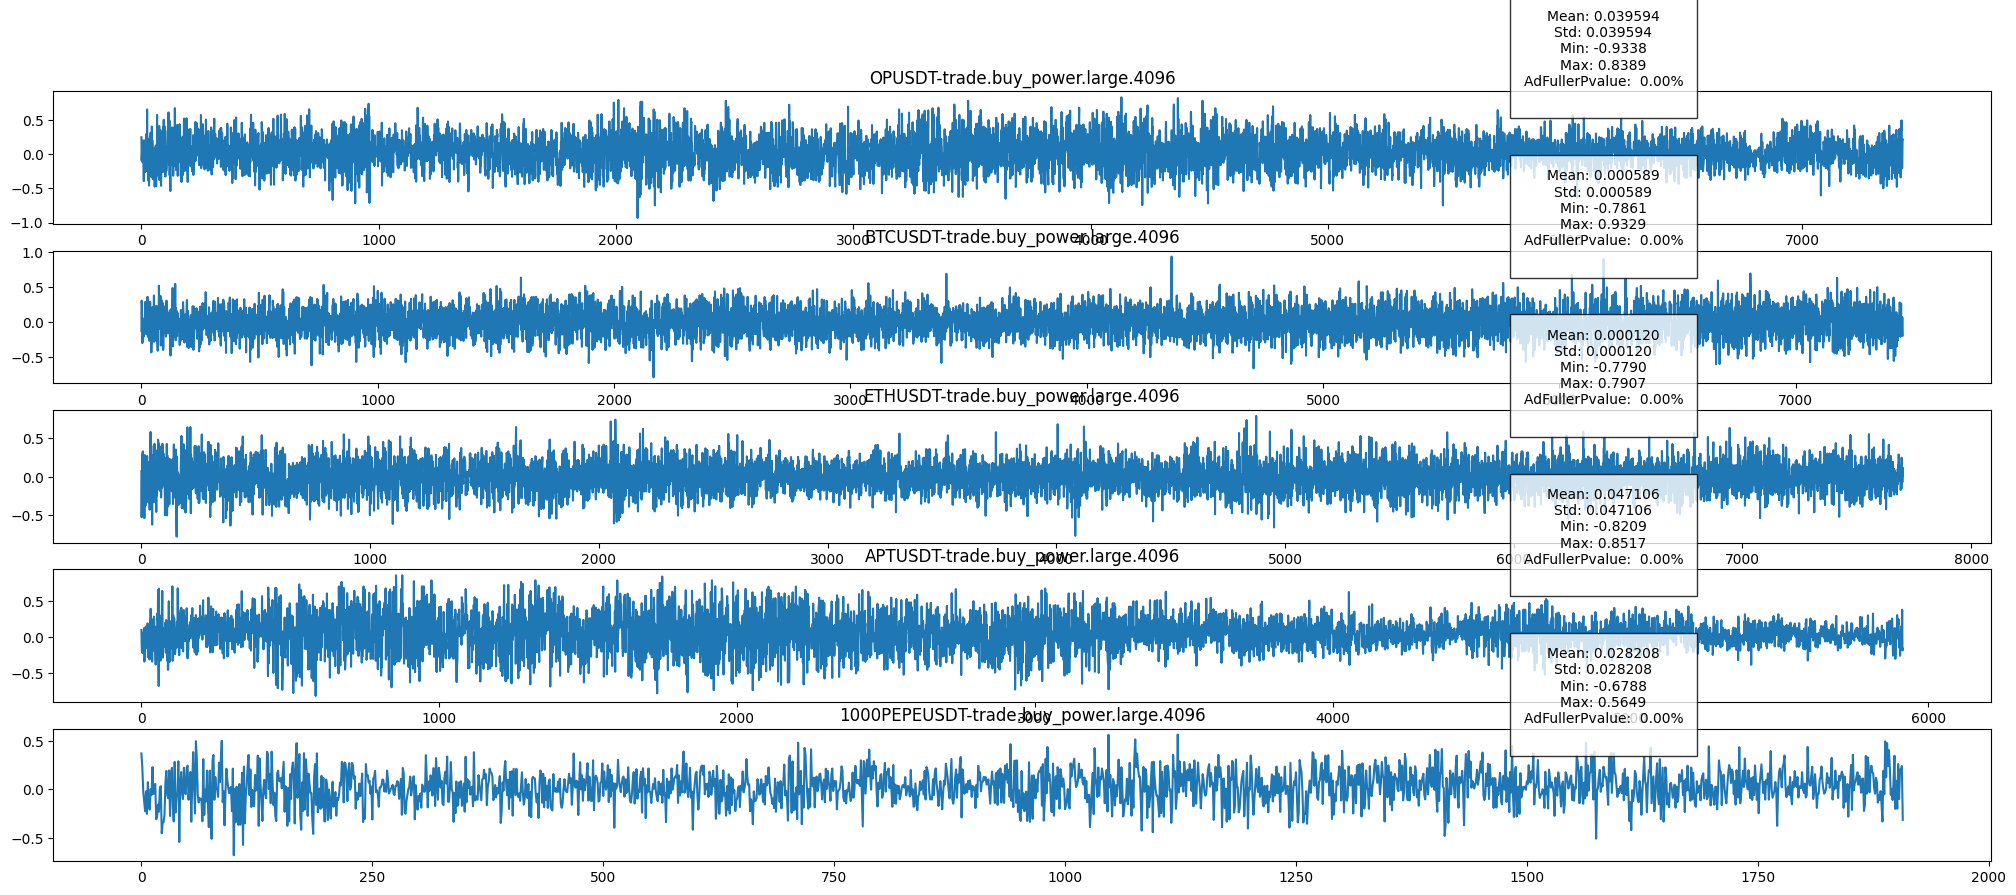

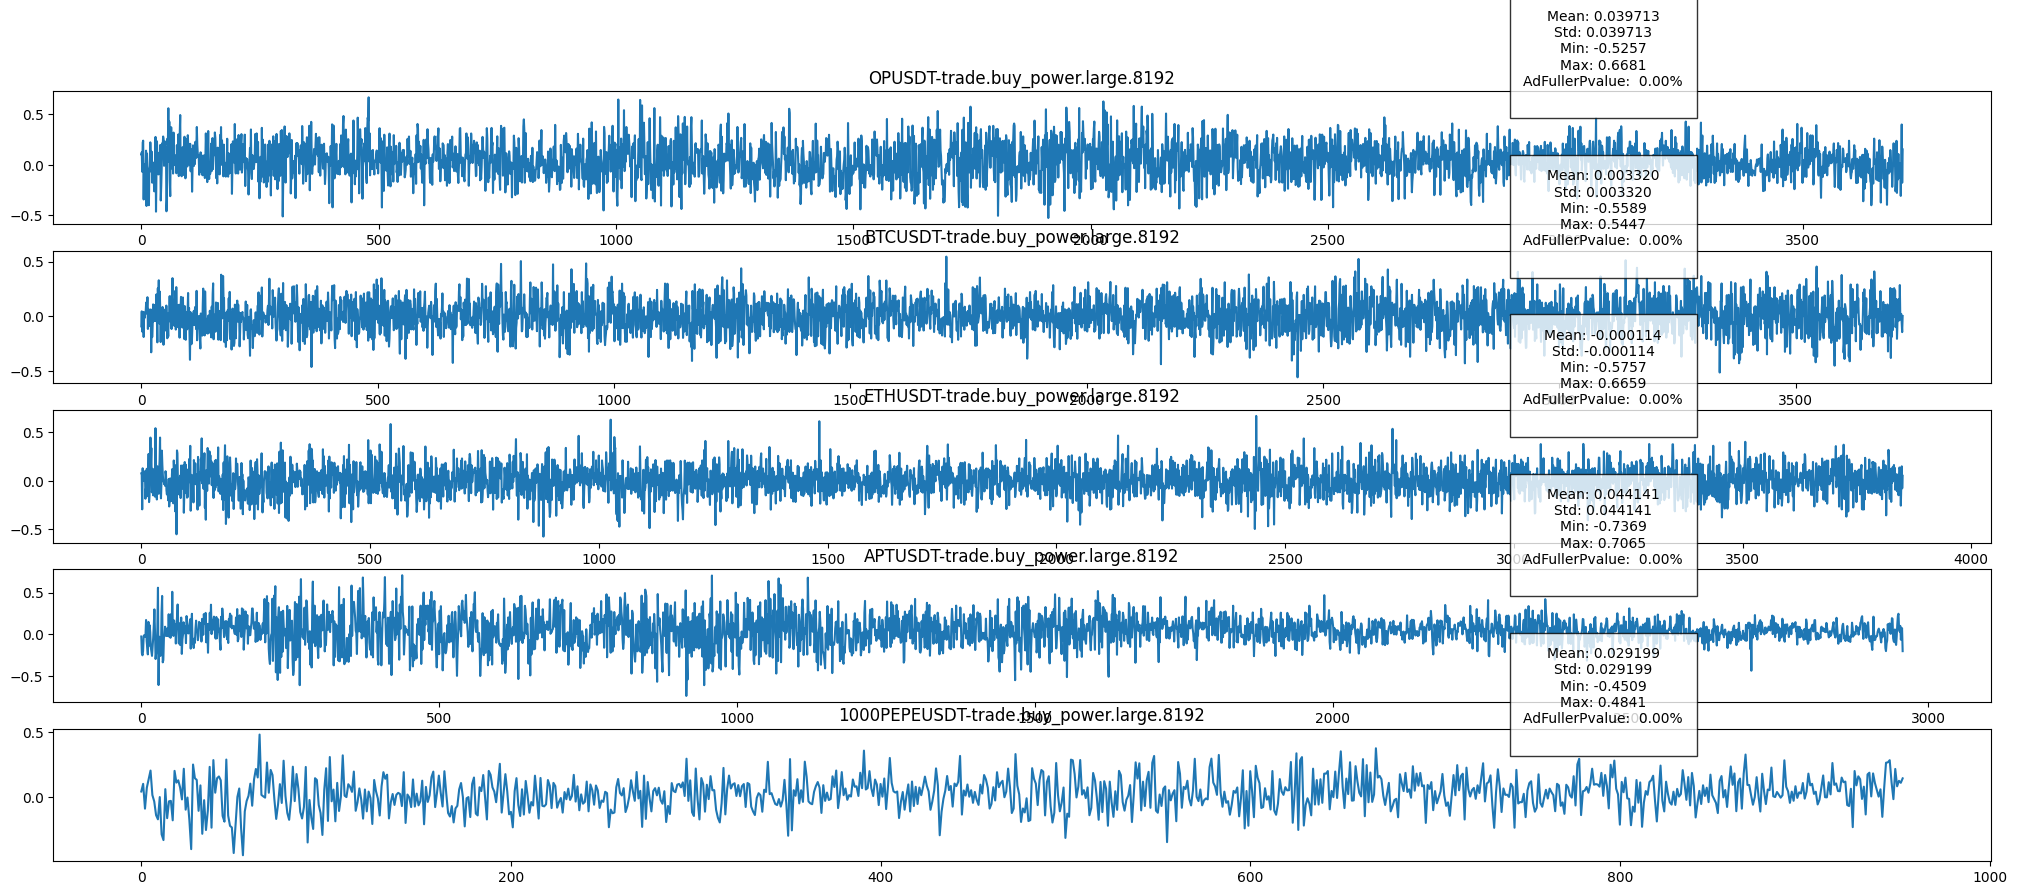

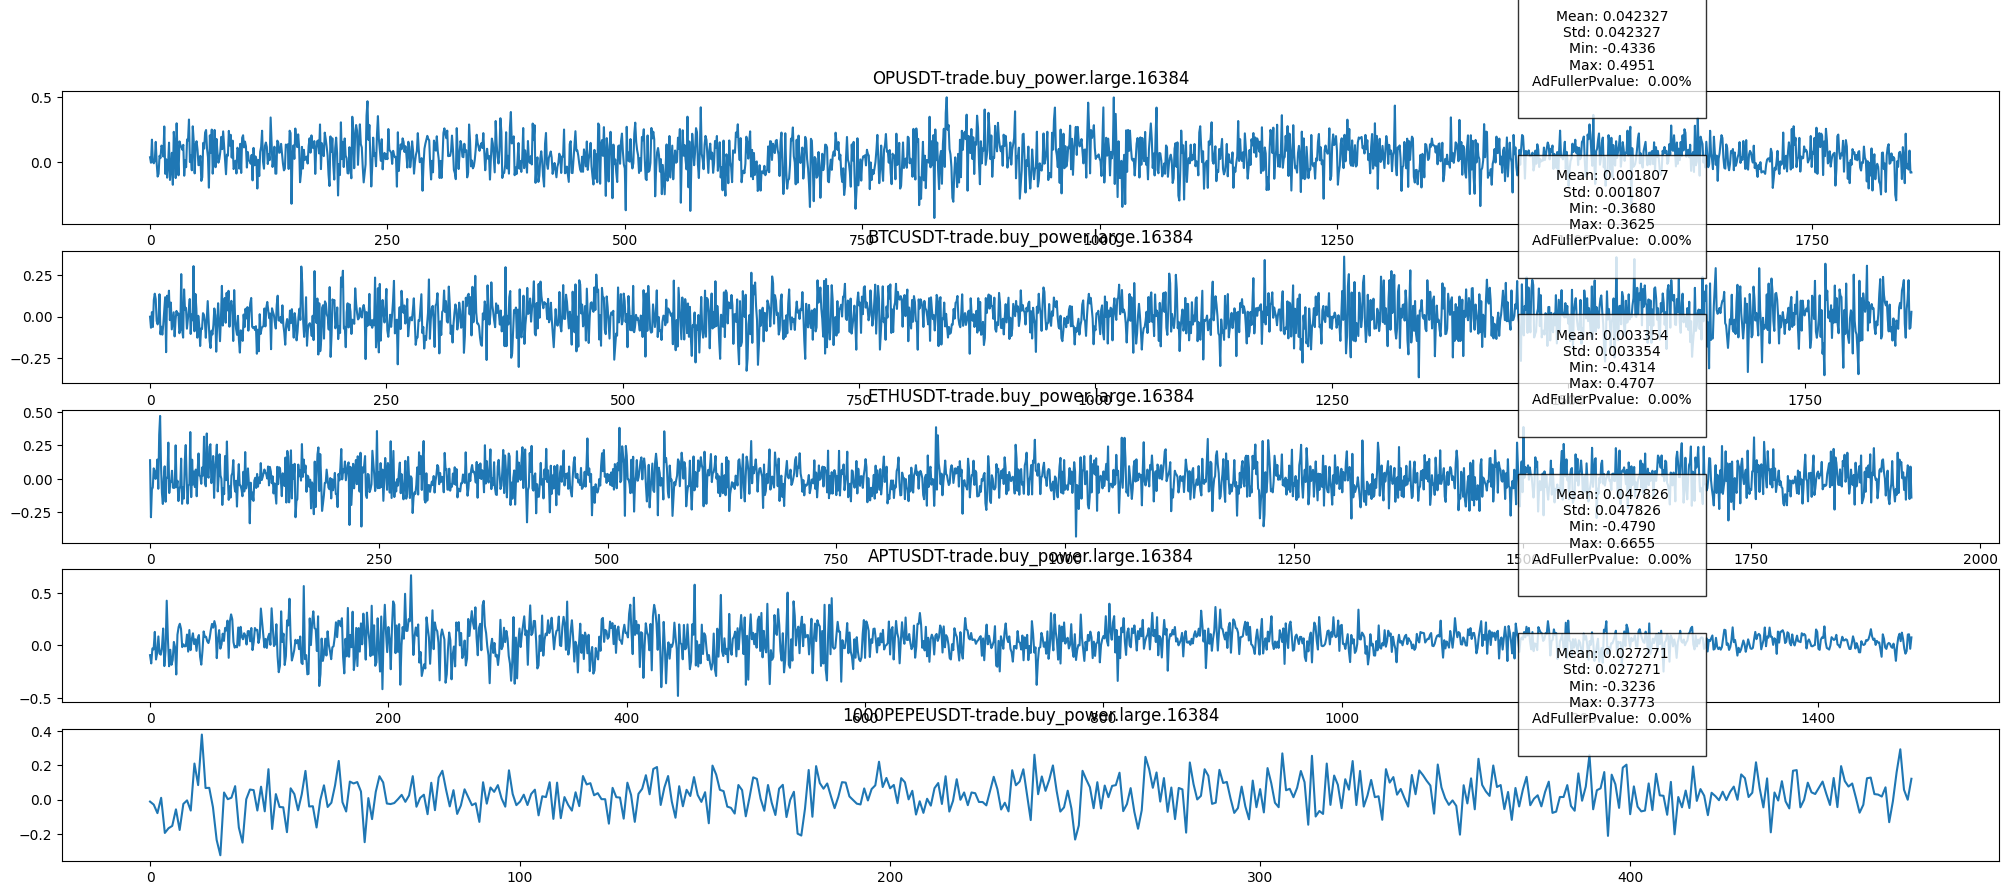

In [6]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        arr[np.isnan(arr)] = 0
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

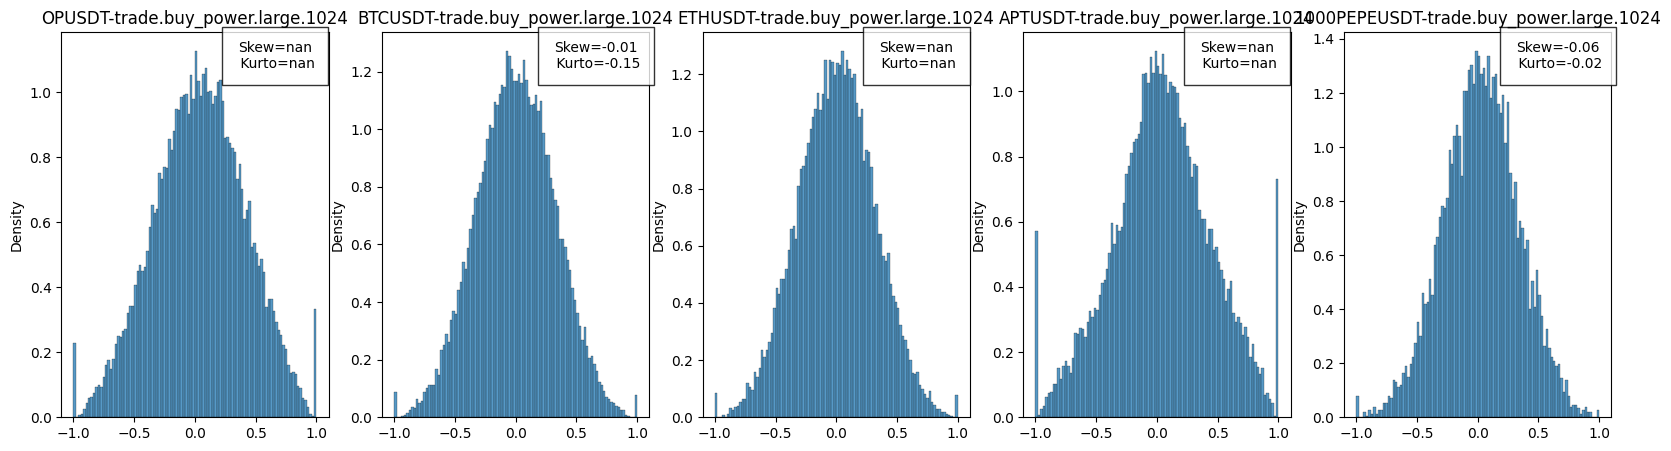

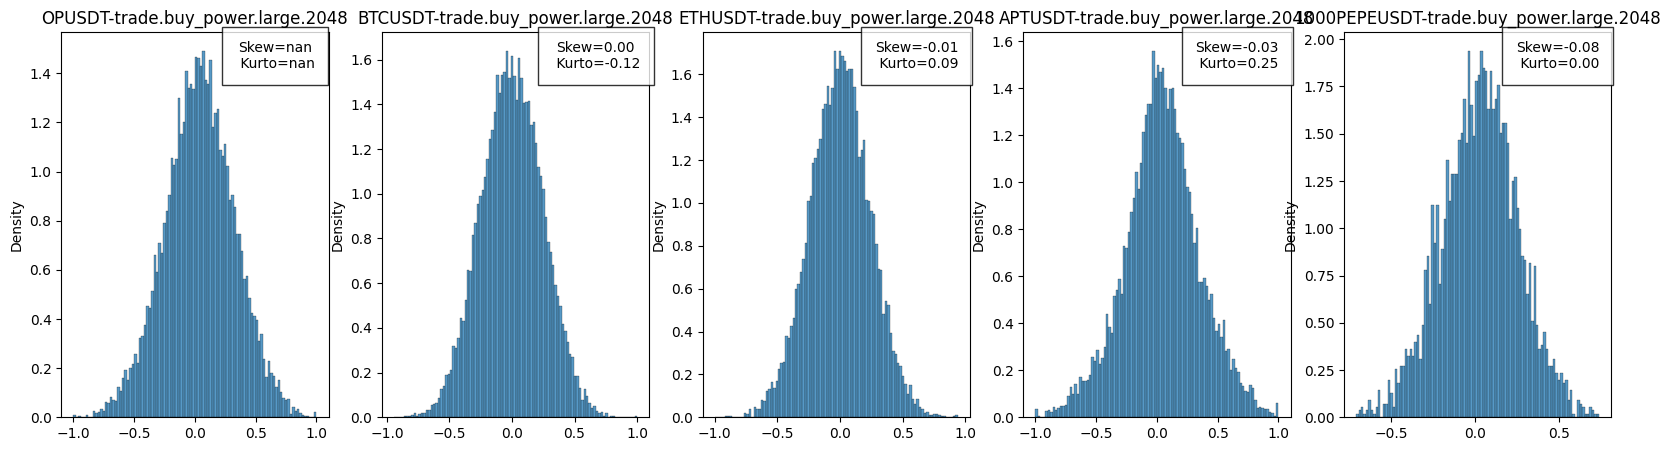

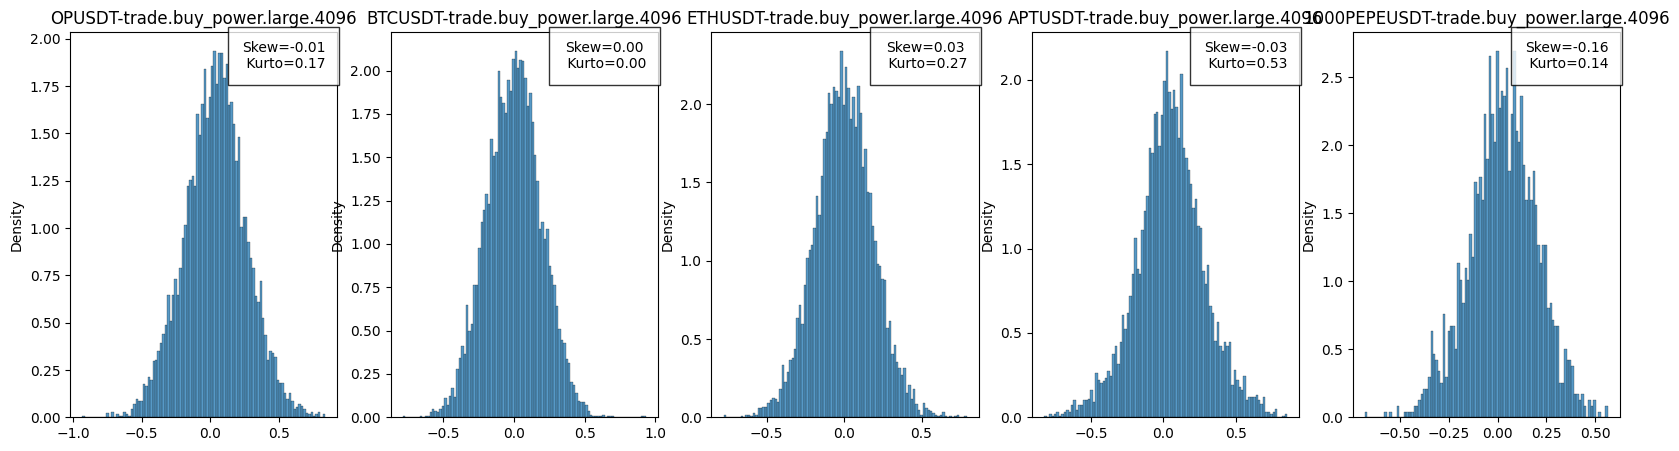

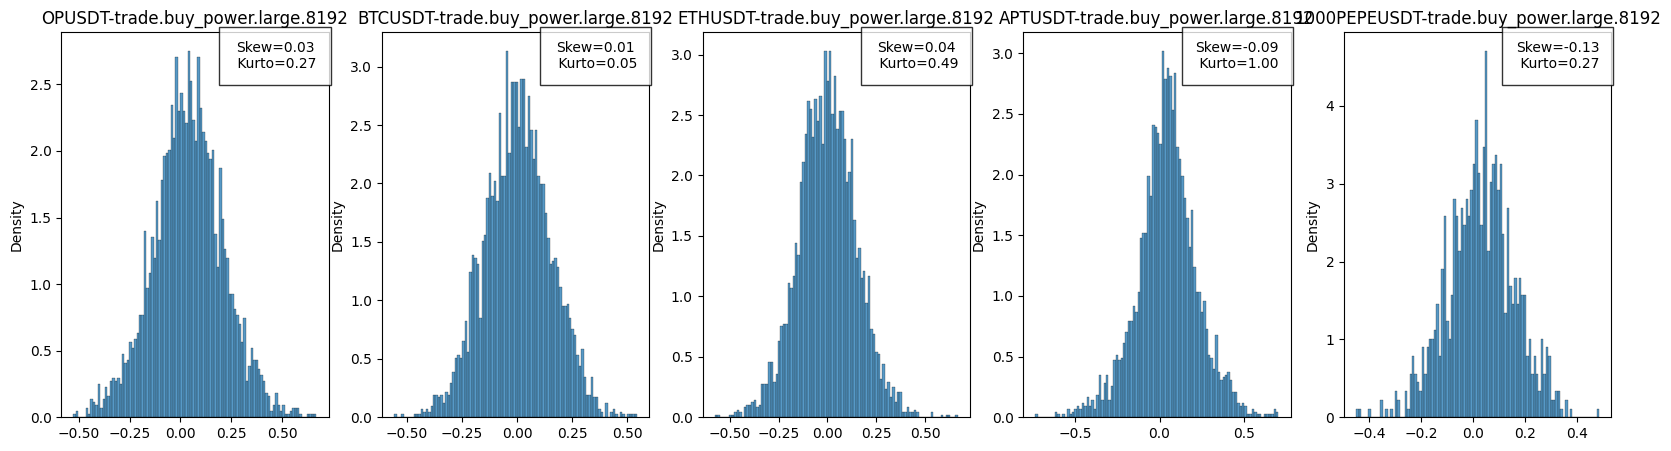

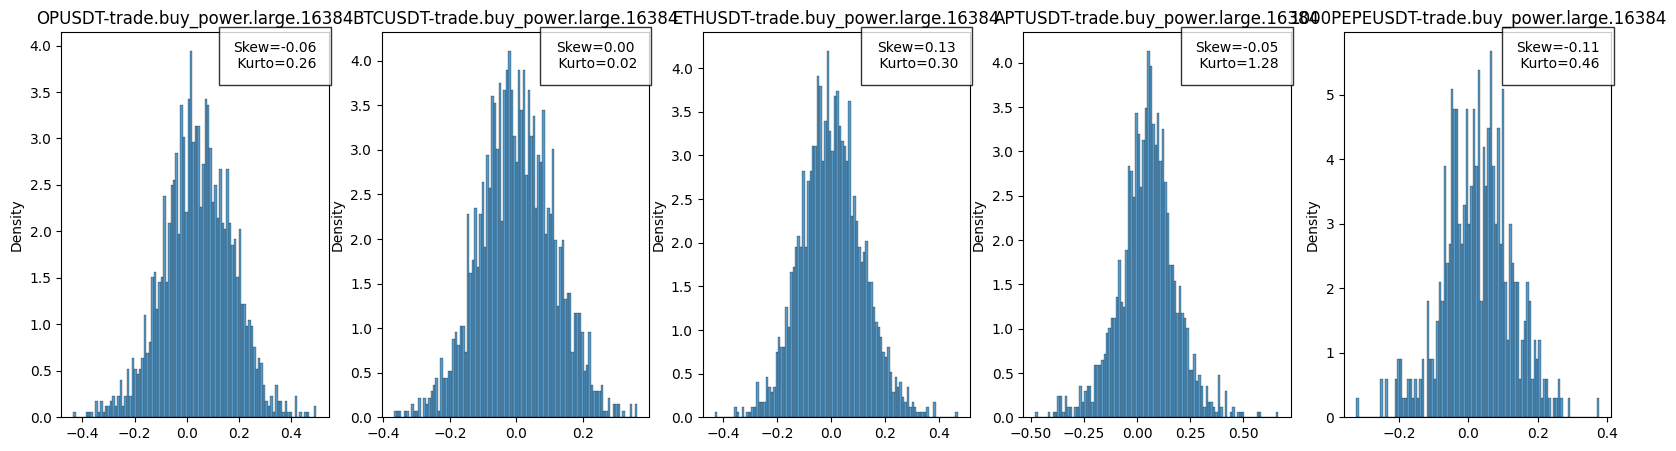

In [7]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

In [ ]:
%%time

for product in product_list:
    dire_signal_list_with_period = [signal_name_format.format(period=period) for period in periods]
    all_dates = helper.get_dates_list(product)
    helper.parLapply(dire_signal_list_with_period, helper.par_generate_alldates_signal, date_list=all_dates, product=product, period=2048)
    

In [ ]:
from research.orderbook_strategies.utils.product_info import product_info
from tqdm.notebook import tqdm
import traceback

with tqdm(total=len(product_list) * len(periods)) as bars:
        for product in product_list:
            spread = product_info[product]["spread"]
            tranct = 0
            tranct_ratio = product_info[product]["tranct.ratio"]
            all_dates = np.array(helper.get_dates_list(product))
            for period in periods:
                signal_name = signal_name_format.format(period=period)
                print("signal: {}, product:{}".format(signal_name, product))
                try:
                    if product == "1000PEPEUSDT":
                        split_str = "2023-06-10"
                    else:
                        split_str = "2023-04-01"
                    factor_analysis.evaluate_signal(signal_name, all_dates, product,
                                                    period=None,
                                                    split_str=split_str,
                                                    tranct=tranct,
                                                    max_spread=spread*1.8,
                                                    atr_filter=0.01,  # 波动大于1%
                                                    save_path="signal_result_with_atr")
                except Exception as e:
                    traceback.print_exc()
                    print("Error in {}: {}".format(product, signal_name))
                    
                bars.update(1)



In [6]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

open file failed: /Volumes/AdamDrive/experiment_root/orderbook_research/signal_results/signal_result_with_atr/APTUSDT.trade.buy_power.large.1024.trend.pkl, e=[Errno 2] No such file or directory: '/Volumes/AdamDrive/experiment_root/orderbook_research/signal_results/signal_result_with_atr/APTUSDT.trade.buy_power.large.1024.trend.pkl'
/Volumes/AdamDrive/experiment_root/orderbook_research/signal_results/signal_result_with_atr/APTUSDT.trade.buy_power.large.1024.trend.pkl not found 
open file failed: /Volumes/AdamDrive/experiment_root/orderbook_research/signal_results/signal_result_with_atr/1000PEPEUSDT.trade.buy_power.large.1024.trend.pkl, e=[Errno 2] No such file or directory: '/Volumes/AdamDrive/experiment_root/orderbook_research/signal_results/signal_result_with_atr/1000PEPEUSDT.trade.buy_power.large.1024.trend.pkl'
/Volumes/AdamDrive/experiment_root/orderbook_research/signal_results/signal_result_with_atr/1000PEPEUSDT.trade.buy_power.large.1024.trend.pkl not found 
open file failed: /Vo

,signal,reverse,num_good_product,good_product,good_product_sharpe,trainSharpe,testSharpe,trainSharpeV2,testSharpeV2,trainAvgDailyTradeNum,testAvgDailyTradeNum,sum_good_strat,avgTrainRet,avgTestRet,trainReturn,testReturn
0,trade.buy_power.large.2048,reverse,1,ETHUSDT,1.57,1.567687,-1.419155,1.567687,-1.419155,6.480716,1.238462,5,0.002179,-0.001132,0.527335,-0.147140
3,trade.buy_power.large.8192,trend,2,"OPUSDT,BTCUSDT","0.25,1.96",1.106291,0.003460,0.248728,-0.564651,7.569674,4.533767,30,0.000826,-0.000045,0.194293,-0.006060
2,trade.buy_power.large.4096,trend,2,"OPUSDT,BTCUSDT","0.94,1.24",1.088772,-1.009592,0.935436,-2.161740,5.075343,2.687925,19,0.000991,-0.000783,0.236593,-0.100997
